In [ ]:
import os
import re
from collections import defaultdict

import numpy as np
import pandas as pd
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl

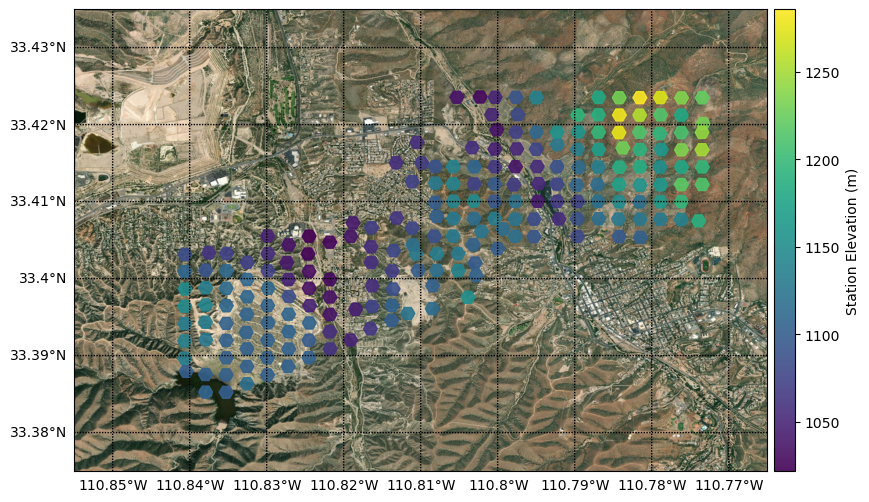

In [ ]:
file_path = '2022_OCELOT_deployement_summary.xlsx' 

df = pd.read_excel(file_path)

Latitude  = df['Latitude'].to_numpy()
Longitude = df['Longitude'].to_numpy()
Elevation = df['Elevation'].to_numpy()


mpl.rcParams['figure.figsize'] = [12, 6]

m = Basemap(resolution='i',projection='cyl',
            llcrnrlat=33.375,urcrnrlat=33.435,\
            llcrnrlon=-110.855,urcrnrlon=-110.765)

m.arcgisimage(service='World_Imagery', xpixels=2000, dpi=300, verbose=False)
m.drawstates()
im1 = m.scatter(Longitude,Latitude,100,marker='H',c=Elevation, alpha=0.9)
m.drawparallels(np.arange(33.38,33.44,0.01),labels=[1,0,0,1])
m.drawmeridians(np.arange(-110.85,-110.76,0.01),labels=[1,0,0,1])
cb = m.colorbar(im1,"right", size="3%", pad="1%",label="Station Elevation (m)")
# plt.savefig('./Figures/stations.png',dpi=300, bbox_inches='tight')

In [ ]:
folder_path = '/data2/BHP_ocelot/BHP_OCELOT_DATA/RAW/MSEED' 

pattern = re.compile(r'(\d+)\.\..*?(\d{4}\.\d{2}\.\d{2})')

station_dates = defaultdict(list)

for fname in os.listdir(folder_path):
    match = pattern.match(fname)
    if match:
        station_code = match.group(1)
        date_str = match.group(2)
        station_dates[station_code].append(date_str)

stats = []

for station, dates in station_dates.items():
    
    date_objs = sorted([datetime.strptime(d, "%Y.%m.%d") for d in dates])
    start = date_objs[0]
    end = date_objs[-1]
    total_days = (end - start).days + 1
    missing_days = []
    for i in range(1, total_days):
        gap = (date_objs[i] - date_objs[i-1]).days
        if gap > 1:
            
            for j in range(1, gap):
                missing_days.append(date_objs[i-1] + timedelta(days=j))
    is_continuous = len(missing_days) == 0
    stats.append({
        "Station": station,
        "Start": start.strftime("%Y-%m-%d"),
        "End": end.strftime("%Y-%m-%d"),
        "Total Days": total_days,
        "Missing Days": len(missing_days),
        "Continuous": is_continuous,
        "Missing Dates": [d.strftime("%Y-%m-%d") for d in missing_days]
    })

df = pd.DataFrame(stats)


if station_dates:
    all_station_date_sets = [
        set(datetime.strptime(d, "%Y.%m.%d") for d in dates)
        for dates in station_dates.values()
    ]
    common_dates = set.intersection(*all_station_date_sets)
    if common_dates:
        common_dates_sorted = sorted(common_dates)
        common_start = common_dates_sorted[0]
        common_end = common_dates_sorted[-1]
        common_total = len(common_dates)

        is_common_continuous = (common_end - common_start).days + 1 == common_total

        summary_row = {
            "Station": "ALL (common)",
            "Start": common_start.strftime("%Y-%m-%d"),
            "End": common_end.strftime("%Y-%m-%d"),
            "Total Days": common_total,
            "Continuous": is_common_continuous,
        }
        df = pd.concat([df, pd.DataFrame([summary_row])], ignore_index=True)
        print("\nCommon available date range for all stations:")
        print(f"Start: {common_start.strftime('%Y-%m-%d')} | End: {common_end.strftime('%Y-%m-%d')} | Total Common Days: {common_total}")
        print("\nWith summary row:")
        print(df[["Station", "Start", "End", "Total Days", "Continuous"]])
    else:
        print("No common dates available for all stations.")

output_path = "/home/syuan/BHP/Results/station_stats.xlsx"  
# df.to_excel(output_path, index=False)



Common available date range for all stations:
Start: 2022-07-16 | End: 2022-07-31 | Total Common Days: 16

With summary row:
          Station       Start         End  Total Days  Continuous
0       453000034  2022-07-15  2022-08-07          24        True
1       453000038  2022-07-15  2022-08-06          23        True
2       453000047  2022-07-11  2022-08-03          24        True
3       453000052  2022-07-14  2022-08-05          23        True
4       453000059  2022-07-14  2022-08-06          24        True
..            ...         ...         ...         ...         ...
203     453010854  2022-07-14  2022-08-12          30        True
204     453010866  2022-07-13  2022-08-11          30        True
205     453010876  2022-07-13  2022-08-11          30        True
206     453010926  2022-07-15  2022-08-12          29        True
207  ALL (common)  2022-07-16  2022-07-31          16        True

[208 rows x 5 columns]


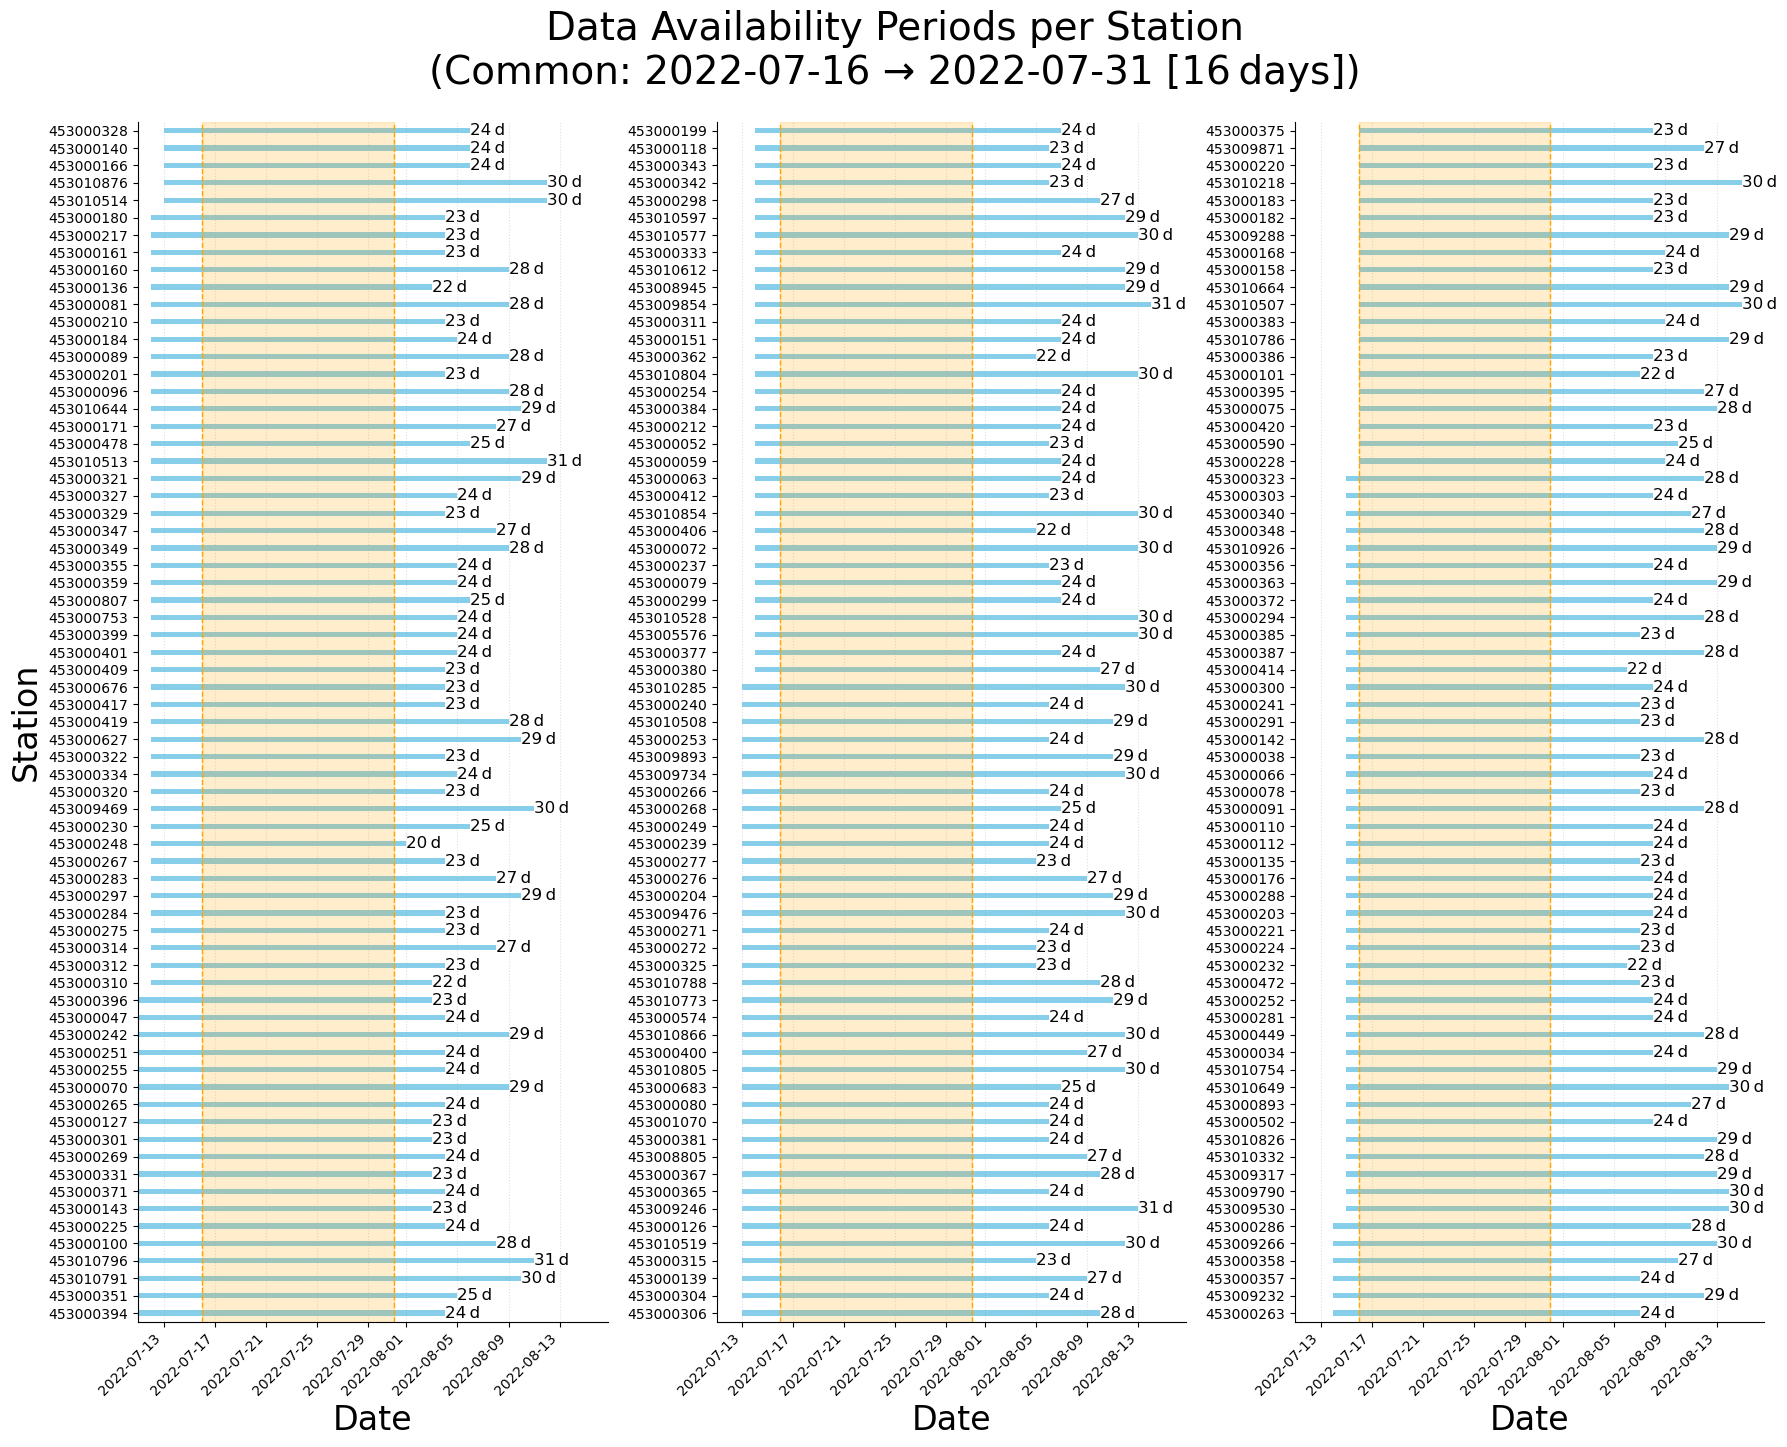

In [ ]:
common_len = (common_end - common_start).days + 1
common_info = f"(Common: {common_start.date()} → {common_end.date()} [{common_len} days])"

n = len(df_plot)
third = (n + 2)//3
chunks = [
    df_plot.iloc[i*third : min((i+1)*third, n)].reset_index(drop=True)
    for i in range(3)
]

fig, axes = plt.subplots(
    1, 3,
    sharex=True,
    figsize=(18, max(4, third * 0.22)) 
)

def plot_chunk(ax, subdf):
    for _, row in subdf.iterrows():
        ax.barh(
            row['Station'],
            (row['End'] - row['Start']).days + 1,
            left=row['Start'],
            height=0.3,
            color='skyblue'
        )
        ax.text(
            row['End'] + pd.Timedelta(days=1),
            row['Station'],
            f"{row['Total Days']} d",
            va='center', fontsize=12
        )
    
    ax.axvspan(common_start, common_end, color='orange', alpha=0.2)
    ax.axvline(common_start, color='orange', linestyle='--', lw=1)
    ax.axvline(common_end,   color='orange', linestyle='--', lw=1)
    
    ax.grid(axis='x', linestyle=':', alpha=0.4)
    ax.margins(y=0)
    ax.set_ylim(-0.5, len(subdf)-0.5)
    for spine in ['top','right']:
        ax.spines[spine].set_visible(False)

for ax, chunk in zip(axes, chunks):
    plot_chunk(ax, chunk)

for ax in axes:
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y‑%m‑%d'))
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_xlabel("Date",fontsize=24)

axes[0].set_ylabel("Station",fontsize=24)

fig.suptitle(
    "Data Availability Periods per Station\n" + common_info,
    fontsize=28, y=0.95
)

plt.tight_layout(rect=[0,0,1,0.95])
# fig.savefig('../Results/data_availability.pdf', bbox_inches='tight')
plt.show()
